# Etiquetage

In [13]:
import itertools
import logging
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from datamaestro import prepare_dataset
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
from typing import List
import time
logging.basicConfig(level=logging.INFO)



In [14]:
ds = prepare_dataset('org.universaldependencies.french.gsd')


# Format de sortie décrit dans
# https://pypi.org/project/conllu/

class Vocabulary:
    """Permet de gérer un vocabulaire.

    En test, il est possible qu'un mot ne soit pas dans le
    vocabulaire : dans ce cas le token "__OOV__" est utilisé.
    Attention : il faut tenir compte de cela lors de l'apprentissage !

    Utilisation:

    - en train, utiliser v.get("blah", adding=True) pour que le mot soit ajouté
      automatiquement s'il n'est pas connu
    - en test, utiliser v["blah"] pour récupérer l'ID du mot (ou l'ID de OOV)
    """
    OOVID = 1
    PAD = 0

    def __init__(self, oov: bool):
        """ oov : autorise ou non les mots OOV """
        self.oov =  oov
        self.id2word = [ "PAD"]
        self.word2id = { "PAD" : Vocabulary.PAD}
        if oov:
            self.word2id["__OOV__"] = Vocabulary.OOVID
            self.id2word.append("__OOV__")

    def __getitem__(self, word: str):
        if self.oov:
            return self.word2id.get(word, Vocabulary.OOVID)
        return self.word2id[word]

    def get(self, word: str, adding=True):
        try:
            return self.word2id[word]
        except KeyError:
            if adding:
                wordid = len(self.id2word)
                self.word2id[word] = wordid
                self.id2word.append(word)
                return wordid
            if self.oov:
                return Vocabulary.OOVID
            raise

    def __len__(self):
        return len(self.id2word)

    def getword(self,idx: int):
        if idx < len(self):
            return self.id2word[idx]
        return None

    def getwords(self,idx: List[int]):
        return [self.getword(i) for i in idx]



class TaggingDataset():
    def __init__(self, data, words: Vocabulary, tags: Vocabulary, adding=True):
        self.sentences = []

        for s in data:
            self.sentences.append(([words.get(token["form"], adding) for token in s], [tags.get(token["upostag"], adding) for token in s]))

    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, ix):
        return self.sentences[ix]

def collate_fn(batch):
    """Collate using pad_sequence"""
    return tuple(pad_sequence([torch.LongTensor(b[j]) for b in batch]) for j in range(2))

In [15]:
logging.info("Loading datasets...")
words = Vocabulary(True)
tags = Vocabulary(False)
train_data = TaggingDataset(ds.train, words, tags, True)
dev_data = TaggingDataset(ds.validation, words, tags, True)
test_data = TaggingDataset(ds.test, words, tags, False)


logging.info("Vocabulary size: %d", len(words))
logging.info("Tag size: %d", len(tags))

VOCAB_SIZE = len(words)
TAG_SIZE = len(tags)

BATCH_SIZE=200

train_loader = DataLoader(train_data, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)




#  TODO:  Implémenter le modèle et la boucle d'apprentissage (en utilisant les LSTMs de pytorch)


INFO:root:Loading datasets...
INFO:root:Vocabulary size: 42931
INFO:root:Tag size: 18


In [16]:
for x,y in train_loader : 

    print(x.shape)
    print(y.shape)
    break

torch.Size([85, 200])
torch.Size([85, 200])


In [17]:
class Seq2Seq(nn.Module) :
    def __init__(self, vocab_size, dim_latent, dim_hidden, tag_size):
        super(Seq2Seq, self).__init__()
        self.emb =  nn.Embedding(vocab_size+1, dim_latent) #+1 pour le OOV
        self.lstm = nn.LSTM(dim_latent, dim_hidden)
        self.decode = nn.Linear(dim_hidden,tag_size) 


    def forward(self,x):
        #print("x : ", x.shape)
        x_emb = self.emb(x)
        #print("x_emb : ", x_emb.shape)
        #x_pack = nn.utils.rnn.pack_padded_sequence(x_emb, l)
        #print("x_pack : ", x_pack.shape)
        output, (hn, cn) = self.lstm(x_emb)
        yhat = self.decode(output)

        return yhat 

In [19]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    liste_loss_epoch = []
    cpt = 0
    for x,y in dataloader :
        #if cpt % 5 == 0 : 
         #   print(f"{cpt}/{len(train_loader)}")
        if torch.rand(1)[0] < 0.1:
            mask = torch.rand(x.shape) < 0.05
            x[mask] = Vocabulary.OOVID
        yhat = model(x)
        yhat = yhat.permute(0, 2, 1)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            liste_loss_epoch.append(loss.item())
        cpt+=1

    return np.mean(liste_loss_epoch)

In [20]:
def evaluate(dataloader, model, loss_fn):
    liste_loss_epoch_eval = []
    cpt = 0
    for x,y in dataloader : 
        #if cpt % 5 == 0:
         #   print(f"{cpt}/{len(train_loader)}")
        with torch.no_grad():
            yhat = model(x)
            yhat = yhat.permute(0, 2, 1)
            loss = loss_fn(yhat, y)
            liste_loss_epoch_eval.append(loss)
        cpt+=1
    return np.mean(liste_loss_epoch_eval)

 

In [21]:
def train_eval(dataloader_train, dataloader_val, nb_epoch, model, loss_fn, optimizer): 
    loss_train = []
    loss_val = []
    for epoch in tqdm(range(nb_epoch)):
        l_train = train_epoch(dataloader_train, model, loss_fn, optimizer)
        loss_train.append(l_train)
        l_val = evaluate(dataloader_val, model, loss_fn)
        loss_val.append(l_val)

    plt.figure()
    plt.plot(np.arange(len(loss_train)), loss_train, label='Loss train', color='tab:orange')
    plt.plot(np.arange(len(loss_val)), loss_val, label='Loss val', color='tab:blue')
    plt.xlabel("Iterations")
    plt.title("Loss en train et en test")
    plt.legend(loc='upper left')
    plt.show()
        

100%|██████████| 3/3 [01:09<00:00, 23.25s/it]


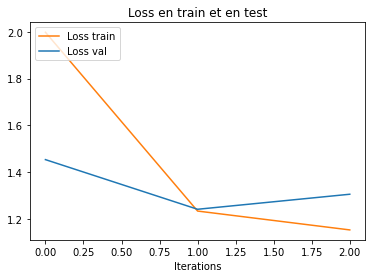

In [27]:
dim_latent= VOCAB_SIZE//50
dim_hidden= dim_latent//100 
NB_EPOCH = 3

model = Seq2Seq(VOCAB_SIZE, dim_latent, dim_hidden, TAG_SIZE)
criterion = nn.CrossEntropyLoss(ignore_index=Vocabulary.PAD)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)


train_eval(train_loader, dev_loader, NB_EPOCH, model, criterion, opt)

    

In [85]:
for x, y in test_loader:
    res = []
    for num_phrase in range(x.shape[1]):
        yhat = model(x[:,num_phrase])
        yhat= torch.argmax(yhat, dim=1)

        if num_phrase ==0:   
            print("x :    ", words.getwords(x[:,num_phrase]))
            print("y :    ",tags.getwords(y[:,num_phrase]))
            print("yhat : ", tags.getwords(yhat))
        
        idx = np.where(x[:,num_phrase]!=Vocabulary.PAD)
        yhat_idx, y_idx = yhat[idx], y[:,num_phrase][idx]
        nb_correct = np.where(yhat_idx==y_idx)[0].size
        #print(f"{nb_correct}/{len(idx[0])}")
        res.append(nb_correct/len(idx[0]))
    print(np.mean(res))
    break

x :     ['__OOV__', ',', 'un', 'film', 'sur', 'la', 'vie', 'de', 'Hughes', '.', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
y :     ['PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'